# Fast Fourier Transform & Denoising
In this kernel, I briefly introduces two ways to perform denoising :
- Using an averaging  smoothing technique
- Using the FFT

##### Enjoy!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.fft import *
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

## 1 - Loading Data

### Signals

In [2]:
signals = pq.read_table('../input/train.parquet', columns=[str(i) for i in range(999)]).to_pandas()

In [3]:
signals = np.array(signals).T.reshape((999//3, 3, 800000))

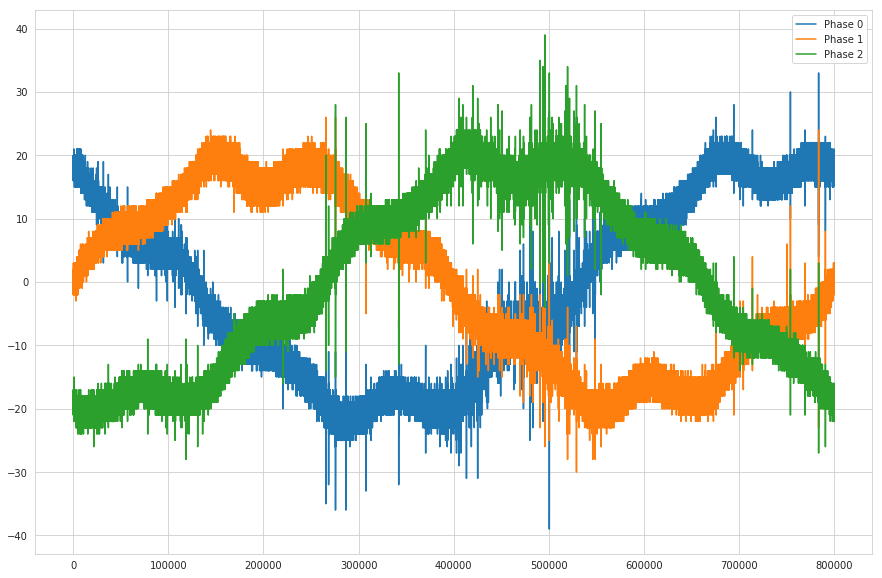

In [4]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Phase 0')
plt.plot(signals[0, 1, :], label='Phase 1')
plt.plot(signals[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

### Target

In [5]:
train_df = pd.read_csv('../input/metadata_train.csv')
train_df.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [6]:
target = train_df['target'][::3]

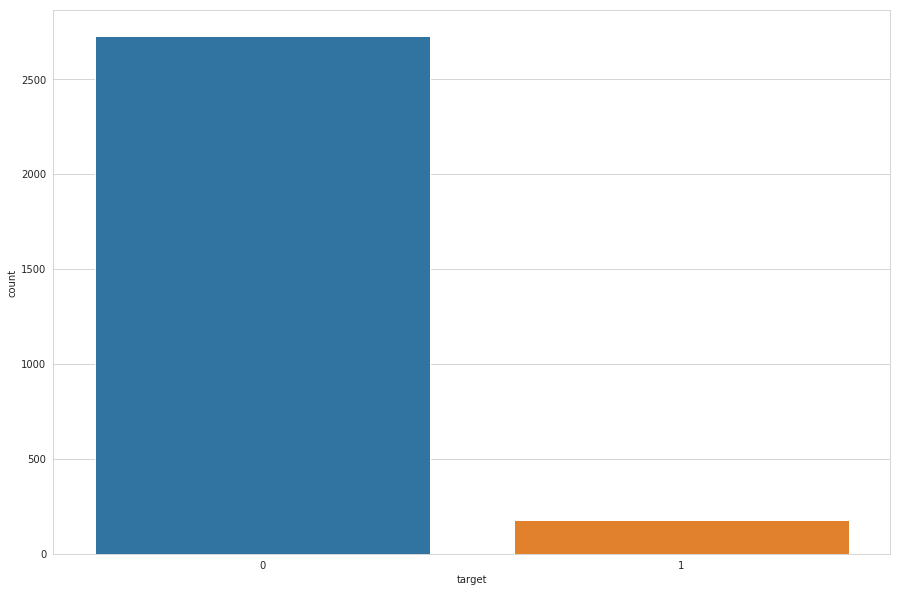

In [7]:
plt.figure(figsize=(15, 10))
sns.countplot(target)
plt.show()

## 2 - Smoothing by mean
The idea is to reduce the length and the noise of the signal by merging $k$ neighbour values into their average.

In [8]:
def sample(signal, kernel_size):
    sampled = np.zeros((signal.shape[0], signal.shape[1], signal.shape[2]//kernel_size))
    for i in range(signal.shape[2]//kernel_size):
        begin = kernel_size * i
        end = min(kernel_size * (i + 1), signal.shape[2])
        sampled[:, :, i] = np.mean(signal[:, :, begin:end], axis=2)
    return sampled

In [9]:
sampled = sample(signals, 100)

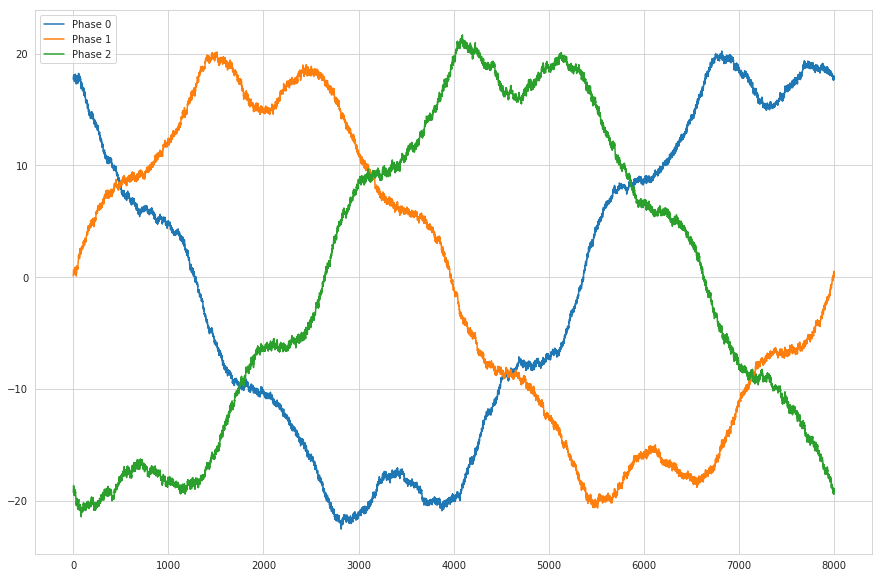

In [10]:
plt.figure(figsize=(15, 10))
plt.plot(sampled[0, 0, :], label='Phase 0')
plt.plot(sampled[0, 1, :], label='Phase 1')
plt.plot(sampled[0, 2, :], label='Phase 2')
plt.legend()
plt.show()

# 3 - Fast Fourier Transform denoising

#### A little bit of maths ...
The Fourier Transform of an 1D signal $x$ of length $n$ is the following : 

> ### $\mathscr{f}_j = \sum_{k=0}^{n-1} x_k e^{\frac{2\pi i}{n} jk} , ~~\forall j=0, ... , n-1$ 

The idea is to represent the signal in the complex space, It is roughly a sum of sinusoïdal functions. And there is one coefficient per frequency present in the signal.

The frequency takes the following values : 
- $f = \frac{1}{dn} [0, 1, \ldots ,   \frac{n}{2}-1,  -\frac{n}{2}, \ldots , -1] $  if $n$ is even
- $f =\frac{1}{dn}  [0, 1, \ldots,  \frac{n-1}{2}, -\frac{n-1}{2}, \ldots, -1] $   if $n$ is odd

#### Denoising algorithm
The denoising steps are the following :
- Apply the fft to the signal
- Compute the frequencies associated with each coefficient
- Keep only the coefficients which have a low enough frequency (in absolute)
- Compute the inverse fft


In [11]:
def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

### Testing some thresholds

In [12]:
filtered = filter_signal(signals[0, 0, :], threshold=1e3)

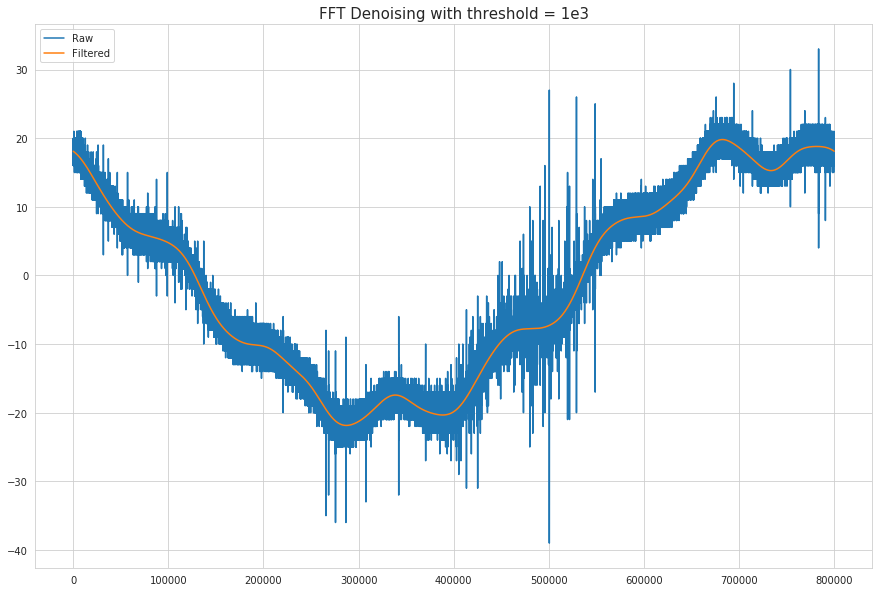

In [13]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e3", size=15)
plt.show()

In [14]:
filtered = filter_signal(signals[0, 0, :], threshold=1e5)

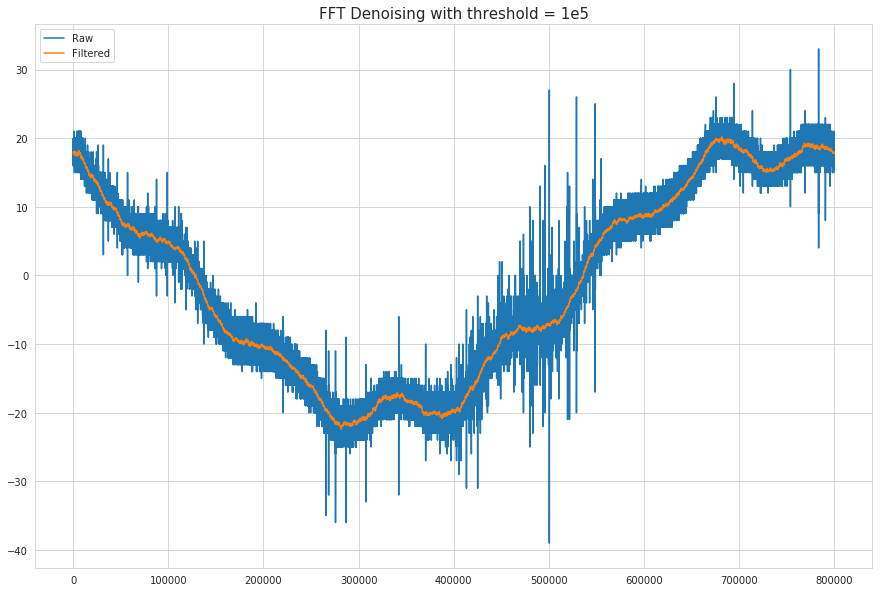

In [15]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e5", size=15)
plt.show()

In [16]:
filtered = filter_signal(signals[0, 0, :], threshold=1e7)

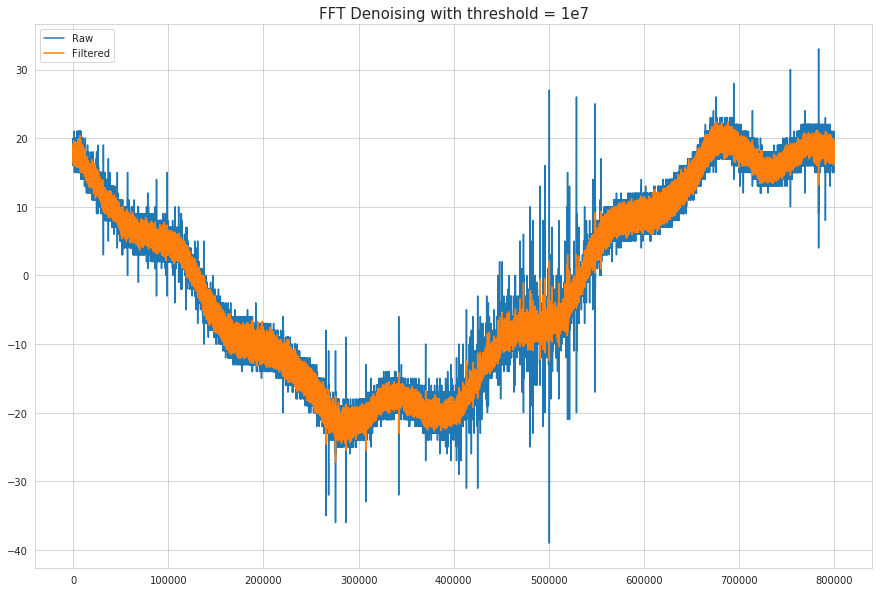

In [17]:
plt.figure(figsize=(15, 10))
plt.plot(signals[0, 0, :], label='Raw')
plt.plot(filtered, label='Filtered')
plt.legend()
plt.title("FFT Denoising with threshold = 1e7", size=15)
plt.show()

### Other uses of the fft ...
The fft coefficients can be used as features to represent the signal. I'll try that in a future kernel.

However, there are too many of them so some more processing has to be done before feeding them into a classifier. Denoising being a solution.

Thats all for now,
#### *Thanks for reading !*
Any feedback is appreciated